In [2]:
import autograd.numpy as anp
import pymanopt
import pymanopt.manifolds
import pymanopt.optimizers
import numpy as np

def offdiag_frobenius_square(A):
    shape = A.shape
    identity_3d = np.zeros(shape)
    idx = np.arange(shape[1])
    identity_3d[:, idx, idx] = 1 
    mask = np.array(1 - identity_3d, dtype = np.int0)
    offdiag = A * mask
    loss = np.sum(np.square(offdiag))
    return loss

def random_error(AA, eps = 1e-5, norm_type = 2):
    n = AA.shape[0]
    p = AA.shape[1]
    result = []
    for A in AA:
        E = np.random.normal(0,1,(p,p))
        E = (E + E.T) / 2
        E = eps * (1/(np.linalg.norm(E,norm_type) *np.sqrt(n))) * E
        result.append(((A + E) + (A + E).T) / 2.0)
    return anp.array(result)

def random_jd_matrices(d = 5, n = 4, orthogonal = False):
    diagonals =np.abs(np.random.normal(size=(d, n)))
    V = np.random.randn(n, n)
    V =  V / np.linalg.norm(V,axis=0)
    if orthogonal:
        V,_ = np.linalg.qr(V)
    C = np.array([V.dot(d[:, None] * V.T) for d in diagonals])
    C = np.array([c / np.linalg.norm(c) for c in C])
    return C

In [2]:
n, p = 10, 30
C = random_jd_matrices(n,p,True)
C = random_error(C, 0)
print(C.shape)

(10, 30, 30)


In [3]:
import mne
from mne.datasets import sample
print(sample)
n = 50
p = 10
data_path = sample.data_path()
raw_fname = str(data_path) + '/MEG/sample/sample_audvis_filt-0-40_raw.fif'
raw = mne.io.read_raw_fif(raw_fname, preload=True)
S = raw.get_data()
# Reduce dimension of X by PCA:
U, D, V = np.linalg.svd(S, full_matrices=False)
S = V[-p:, :]
C = np.array([np.dot(x, x.T) for x in np.split(S, n, axis=1)])
print(C.shape)


<module 'mne.datasets.sample' from 'c:\\program files\\python38\\lib\\site-packages\\mne\\datasets\\sample\\__init__.py'>
Opening raw data file C:\Users\Haoze He\mne_data\MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
Reading 0 ... 41699  =      0.000 ...   277.709 secs...
(50, 10, 10)


In [4]:
manifold = pymanopt.manifolds.Oblique(p,p)
def create_cost_and_derivates():

    @pymanopt.function.numpy(manifold)
    def cost(X):
        return offdiag_frobenius_square(X.T@C@X)

    @pymanopt.function.numpy(manifold)
    def riemannian_gradient(X):
        identity_3d = np.zeros(C.shape)
        idx = np.arange(C.shape[1])
        identity_3d[:, idx, idx] = 1 
        mask = np.array(1 - identity_3d, dtype = np.int0)
        offdiag = (X.T@C@X) * mask
        gradient_matrices = C @ X @ offdiag
        euclidean_gradient = 2 * np.sum(gradient_matrices, axis=0)
        return euclidean_gradient - X.T@np.diag(np.diag(X.T@euclidean_gradient))
    
    @pymanopt.function.numpy(manifold)
    def euclidean_gradient(X):
        identity_3d = np.zeros(C.shape)
        idx = np.arange(C.shape[1])
        identity_3d[:, idx, idx] = 1 
        mask = np.array(1 - identity_3d, dtype = np.int0)
        offdiag = (X.T@C@X) * mask
        gradient_matrices = C @ X @ offdiag
        euclidean_gradient = 2 * np.sum(gradient_matrices, axis=0)
        return euclidean_gradient

    @pymanopt.function.numpy(manifold)
    def euclidean_hessian(X,Z):
        identity_3d = np.zeros(C.shape)
        idx = np.arange(C.shape[1])
        identity_3d[:, idx, idx] = 1 
        mask = np.array(1 - identity_3d, dtype = np.int0)
        offdiag_XX = 2*np.sum(C@Z@(X.T@C@X) * mask, axis=0)
        offdiag_ZX = 2*np.sum(C@X@(Z.T@C@X) * mask, axis=0)
        offdiag_XZ = 2*np.sum(C@X@(X.T@C@Z) * mask, axis=0)
        return offdiag_XX + offdiag_ZX + offdiag_XZ

    return cost, riemannian_gradient, euclidean_gradient, euclidean_hessian

In [120]:
cost, riemannian_gradient, euclidean_gradient, euclidean_hessian = create_cost_and_derivates()

problem = pymanopt.Problem(
        manifold,
        cost,
        riemannian_gradient=riemannian_gradient,
)

optimizer = pymanopt.optimizers.ConjugateGradient(max_iterations=10000,verbosity=1,log_verbosity=1)
result = optimizer.run(problem)

Optimizing...
Terminated - min step_size reached after 78 iterations, 0.04 seconds.



In [121]:
print(np.diag(result.point.T@result.point))
print(np.linalg.norm(result.point.T@result.point - np.identity(p)))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
0.022172677847018322


In [122]:
print(offdiag_frobenius_square(result.point.T@C@result.point))

0.002799228530033839


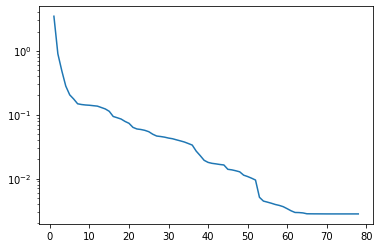

In [123]:
import matplotlib.pyplot as plt
plt.semilogy(optimizer._log["iterations"]['iteration'],optimizer._log["iterations"]['cost'])

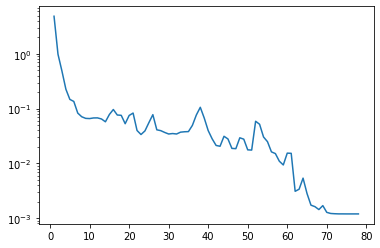

In [124]:
import matplotlib.pyplot as plt
plt.semilogy(optimizer._log["iterations"]['iteration'],optimizer._log["iterations"]['gradient_norm'])

In [125]:
from scipy.linalg.lapack import dsygv,dggev
from time import time
def runif_in_simplex(AA):
    
    n = AA.shape[0]
    k = np.random.exponential(scale=1.0, size=n)
    k /= sum(k)
    A_mu = np.einsum('ijk,i->jk',AA, k)
    return A_mu

def random_combination(AA):
    """
    Diagonlize a random linear combination of an array of matrices
    AA: of shape (d,n,n)
    d: # of matrices

    return: the orthognoal matrix Q
    """
    mu = np.random.normal(0,1,AA.shape[0])
    A_mu = np.einsum('ijk,i->jk',AA, mu)
    return A_mu
start = time()
_, _, _, _, X, _, _ = dggev(random_combination(C), np.mean(C,axis=0))
X_norm = X / anp.linalg.norm(X,axis=0)
print("Solved the GEVP in " + str(time()-start)+'s')
print("Error: ", offdiag_frobenius_square(X_norm.T@C@X_norm))

Solved the GEVP in 0.0009932518005371094s
Error:  0.0028417508598843986


In [126]:
problem = pymanopt.Problem(
        manifold,
        cost,
        riemannian_gradient=riemannian_gradient,
        #euclidean_hessian=euclidean_hessian,
)


optimizer = pymanopt.optimizers.ConjugateGradient(max_iterations=10000,verbosity=1,log_verbosity=1)
result = optimizer.run(problem,initial_point=X_norm)

Optimizing...
Terminated - min step_size reached after 9 iterations, 0.01 seconds.



0.0028387994985284125
0.001575584383511112
0.0038162723883412887


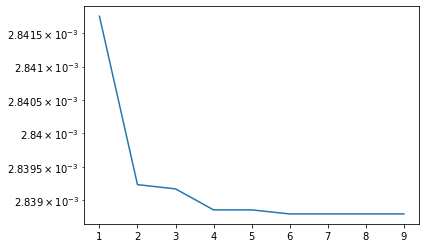

In [130]:
print(offdiag_frobenius_square(result.point.T@C@result.point))
print(np.linalg.norm(result.point.T@result.point - np.identity(p)))
print(offdiag_frobenius_square(C))
import matplotlib.pyplot as plt
plt.semilogy(optimizer._log["iterations"]['iteration'],optimizer._log["iterations"]['cost'])

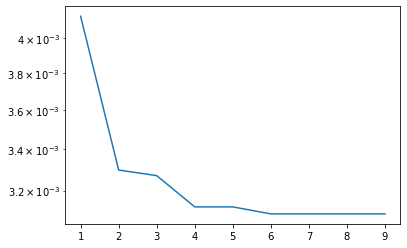

In [131]:
import matplotlib.pyplot as plt
plt.semilogy(optimizer._log["iterations"]['iteration'],optimizer._log["iterations"]['gradient_norm'])

In [129]:
optimizer._log['stopping_criteria']

{'max_time': 1000,
 'max_iterations': 10000,
 'min_gradient_norm': 1e-06,
 'min_step_size': 1e-10,
 'max_cost_evaluations': 5000}

In [114]:
from qndiag import qndiag

X, infos = qndiag(C, return_B_list=True)
X = X / np.linalg.norm(X,axis=0)

In [115]:
print(offdiag_frobenius_square(X@C@X.T))

0.02801755133173823


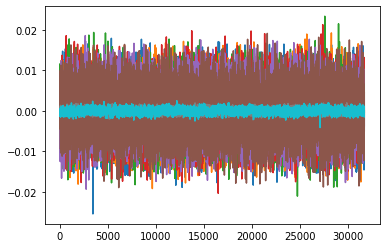

In [116]:
plt.plot(S.T[10000:])

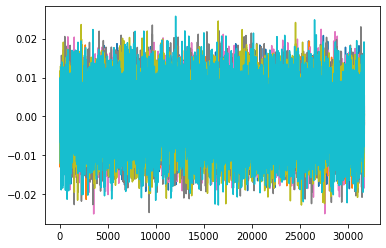

In [132]:
plt.plot((X@S).T[10000:])

In [ ]:
import h5py
import numpy as np
from pyriemann.utils.ajd import ajd_pham, rjd
from jd_algorithms import randomized_jd, randomized_jd_deflat, qndiag, rnojd, offdiagonal_frobenius_square
from time import time
def check_symmetric(a, rtol=1e-05, atol=1e-08):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)